# `Setup`

This notebook is built to for performing cross validation training for models to evaluate dataset split effects

### Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
from math import ceil
import csv
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset
import warnings
warnings.filterwarnings('ignore')

# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")
    
from utils.models.EfficientNet import EfficientNet

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


In [2]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install torchvision
# !pip install torch

### `Split Generator`

In [3]:
def cross_validation_generator(config:dict):
    """Function for generating cross validation splits for our dataset"""
    # Seed for reproducability
    seed = 42
    
    # Extract all data (excl. holdout data for later use)
    data = StateFarmDataset(config).metadata[['subject','target']]
    
    # Generate subject counts for our dataset
    subjects_count = data.groupby('subject').count().reset_index().rename(columns={'target':'counts'}).sort_values('counts', ascending=False)
    
    # Shuffle around
    subjects_count = subjects_count.sample(frac=1, random_state = seed).reset_index(drop=True)
    
    
    # Extract subjects for Val + Test
    cv_split = 1
    subject_split = pd.DataFrame(columns=['subject','split', 'cv_round'])
    
    # Looping through subjects - ensuring subjects are only once in either val or test
    for i in range(0, 20, 4):
        # Subjects per test and val split
        num_subjects = 2
        
        # Lower and upper index bound for test split
        test_lower = i
        test_upper = test_lower + num_subjects
        
        # Lower and upper index bound for val split
        val_lower = test_upper
        val_upper = val_lower + num_subjects

        # Extracting Test Subjects
        test_subjects = subjects_count.iloc[test_lower:test_upper].subject.to_list()
        subject_split = pd.concat([subject_split, pd.DataFrame({'subject':test_subjects, 'split':'test', 'cv_round':cv_split})], ignore_index=True)
        
        # Extracting Validation Subjects
        val_subjects = subjects_count.iloc[val_lower:val_upper].subject.to_list()
        subject_split = pd.concat([subject_split, pd.DataFrame({'subject':val_subjects, 'split':'val', 'cv_round':cv_split})], ignore_index=True)

        # Add 1 to cv_split
        cv_split += 1
    return subject_split

In [4]:
# Config file
config = load_config(eval(os.environ["COLAB"]))

# Generating cross validation splits
split = cross_validation_generator(config)

# Loadding Results

In [16]:
# Loading csv's produced during training
tiny_cv = pd.read_csv('outputs/TinyVGG_500k/TinyVgg_500k_20231205_181823_CV_splits.csv')
efficient_cv = pd.read_csv('outputs/EfficientNetB0-30122023_CV/EfficientNetB0-30122023_20231230_132001_CV_splits.csv')

# Adding model name to csv's
tiny_cv['model'] = 'TinyVGG'
efficient_cv['model'] = 'EfficientNetB0'

# Concatenating csv's
cv = pd.concat([tiny_cv, efficient_cv], ignore_index=True)
cv['accuracy_diff'] = cv['test_accuracy'] - cv['val_accuracy']
cv_melt = cv.melt(id_vars=['model','cv_fold'], value_vars=['val_accuracy','test_accuracy'], var_name='metric', value_name='value')

### Displaying Results

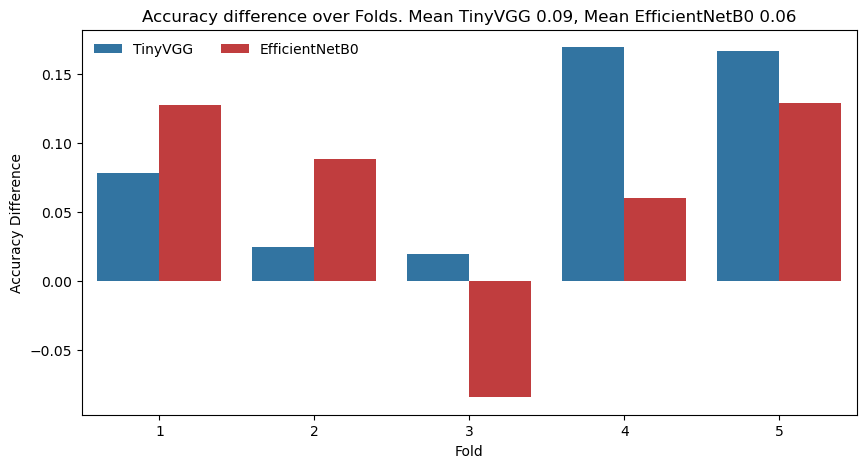

In [6]:
fig, axs = plt.subplots(figsize=(10, 5))

sns.barplot(ax=axs, data=cv, x='cv_fold', y='accuracy_diff', hue='model', palette=['#1f77b4', '#d62728'])
axs.set_title(f'Accuracy difference over Folds. Mean TinyVGG {cv[cv.model == "TinyVGG"].accuracy_diff.mean():.2f}, Mean EfficientNetB0 {cv[cv.model == "EfficientNetB0"].accuracy_diff.mean():.2f}')
axs.set_xlabel('Fold')
axs.set_ylabel('Accuracy Difference')
# Set legend to two columns and no boardera
axs.legend(ncol = 2, frameon=False,loc='upper left')
# sns.barplot(ax=axs[1], 
#             data=cv.groupby('model').agg(mean_test_accuracy = ('test_accuracy', 'mean'), 
#                         mean_val_accuracy = ('val_accuracy', 'mean')).reset_index().melt(id_vars='model', value_vars=['mean_test_accuracy','mean_val_accuracy'], var_name='metric', value_name='value'), 
#             x='model', y='value', hue='metric', palette=['#1f77b4', '#d62728'])

plt.show()

In [17]:
cv_melt

,model,cv_fold,metric,value
0,TinyVGG,1,val_accuracy,0.495192
1,TinyVGG,2,val_accuracy,0.697419
2,TinyVGG,3,val_accuracy,0.788075
3,TinyVGG,4,val_accuracy,0.380826
4,TinyVGG,5,val_accuracy,0.415319
5,EfficientNetB0,1,val_accuracy,0.599359
6,EfficientNetB0,2,val_accuracy,0.610404
7,EfficientNetB0,3,val_accuracy,0.862496
8,EfficientNetB0,4,val_accuracy,0.653602
9,EfficientNetB0,5,val_accuracy,0.533333


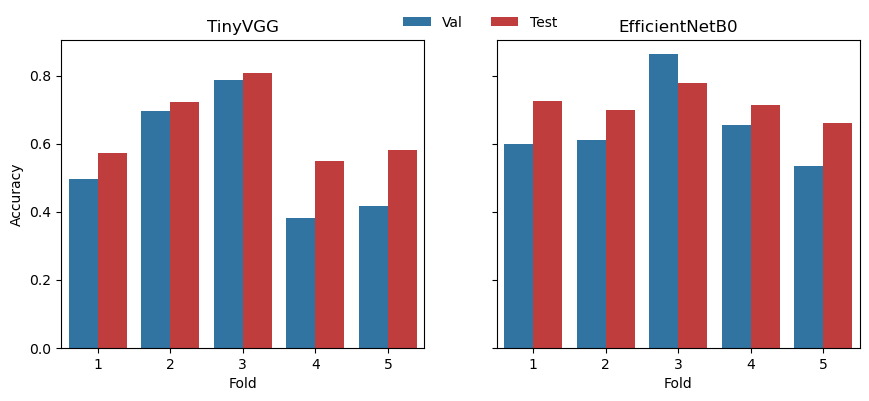

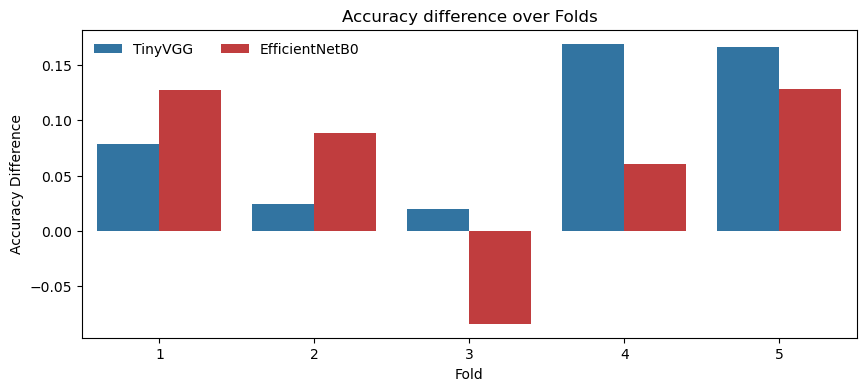

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(10.3, 4), sharey=True)

sns.barplot(ax=axs[0], data=cv_melt[cv_melt.model == 'TinyVGG'].replace({'val_accuracy':'Val','test_accuracy':'Test'}), x='cv_fold', y='value', hue='metric', palette=['#1f77b4', '#d62728'])
axs[0].set_title(f'TinyVGG')
axs[0].set_xlabel('Fold')
axs[0].set_ylabel('Accuracy')
axs[0].legend(ncol = 2, frameon=False, bbox_to_anchor=(1.4, 1.12))

sns.barplot(ax=axs[1], data=cv_melt[cv_melt.model == 'EfficientNetB0'], x='cv_fold', y='value', hue='metric', palette=['#1f77b4', '#d62728'])
axs[1].set_title(f'EfficientNetB0')
axs[1].set_xlabel('Fold')
axs[1].set_ylabel('')
axs[1].legend().remove()

fig, axs = plt.subplots(figsize=(10, 4))

sns.barplot(ax=axs, data=cv, x='cv_fold', y='accuracy_diff', hue='model', palette=['#1f77b4', '#d62728'])
axs.set_title(f'Accuracy difference over Folds')
axs.set_xlabel('Fold')
axs.set_ylabel('Accuracy Difference')
# Set legend to two columns and no boardera
axs.legend(ncol = 2, frameon=False,loc='upper left')
plt.show()

plt.show()